In [1]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from torchvision.transforms import v2
from torchvision.utils import make_grid

from torchinfo import summary

from datasets import load_dataset
from diffusers import DDPMPipeline, DDPMScheduler, UNet2DModel

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [3]:
BATCH_SIZE = 64
IMAGE_SIZE = 32

In [4]:
def plot_grid(images: torch.Tensor) -> None:
    if images.is_cuda:
        images = images.detach().cpu()
    
    plt.imshow(make_grid(images).permute(1, 2, 0))
    plt.show()

In [21]:
transform = v2.Compose([
    v2.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    v2.RandomHorizontalFlip(),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize((0.5,), (0.5,))
])


def transform_data(data):
    images = [transform(image.convert('RGB')) for image in data['image']]
    return {'images': images}


dataset = load_dataset('huggan/smithsonian_butterflies_subset', split='train')
dataset.set_transform(transform_data)

Repo card metadata block was not found. Setting CardData to empty.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([16, 3, 32, 32])


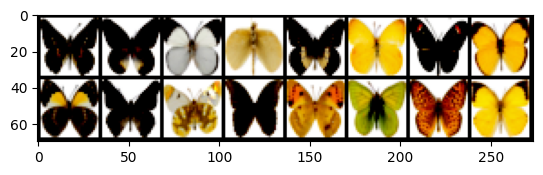

In [6]:
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

for batch in dataloader:
    images = batch['images'][:16]
    break

print(images.shape)
plot_grid(images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


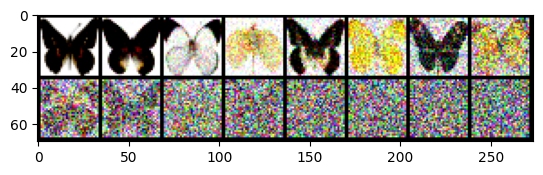

In [7]:
scheduler = DDPMScheduler(num_train_timesteps=1000)
timesteps = torch.linspace(0, 999, 16).long()
noise = torch.rand_like(images)

corrupted_images = scheduler.add_noise(images, noise, timesteps)
plot_grid(corrupted_images)

In [8]:
model = UNet2DModel(
    sample_size=IMAGE_SIZE,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(64, 128, 128, 256),
    down_block_types=(
        'DownBlock2D',
        'DownBlock2D',
        'AttnDownBlock2D',
        'AttnDownBlock2D',
    ),
    up_block_types=(
        'AttnUpBlock2D',
        'AttnUpBlock2D',
        'UpBlock2D',
        'UpBlock2D',
    ),
).to(DEVICE)

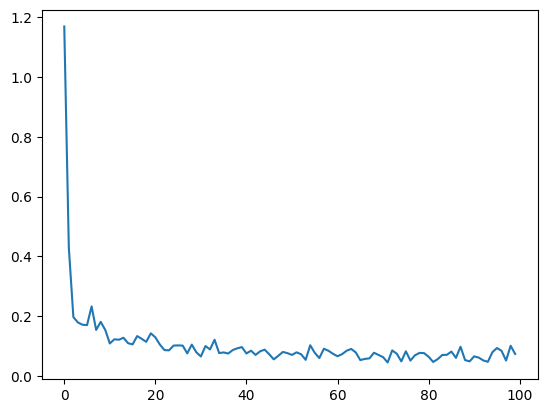

In [9]:
scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)
loss_func = nn.MSELoss()

N_EPOCHS = 25

loss_history = []

for _ in range(N_EPOCHS):
    for i, batch in enumerate(dataloader):
        images = batch['images'].to(DEVICE)
        noise = torch.randn_like(images, device=DEVICE)
        timesteps = torch.randint(0, scheduler.num_train_timesteps,
                                  (images.shape[0],), device=DEVICE).long()
        corrupted_images = scheduler.add_noise(images, noise, timesteps)

        optimizer.zero_grad()
        pred_noise = model(corrupted_images, timesteps, return_dict=False)[0]
        loss = loss_func(pred_noise, noise)
        loss.backward()
        optimizer.step()

        if i % 5 == 0:
            loss_history.append(loss.item())

            clear_output(wait=True)
            plt.plot(loss_history)
            plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

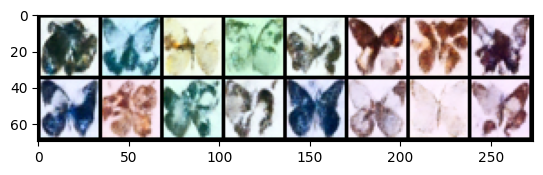

In [24]:
to_tensor = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
])

pipeline = DDPMPipeline(unet=model, scheduler=scheduler)
generated_images = pipeline(16)
images = torch.stack([to_tensor(image) for image in generated_images.images])
plot_grid(images)